In [ ]:
pip install pyAstronomy


In [ ]:
pip install arviz


In [ ]:
import numpy as np
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import io
from PyAstronomy import pyasl
import time
r = pyasl.BallesterosBV_T()
b = pyasl.Ramirez2005()

uploaded = files.upload()

data0 = data = np.array(pd.read_csv(io.BytesIO(uploaded['SItable1.csv'])))

Saving SItable1.csv to SItable1 (1).csv


In [ ]:
import tensorflow.math as tf_m
def mean_fn(x, y, a, b, c, d):
  return (np.exp(x)*1000)**a * b*(y - c)**d #the m relation was through trial and error
#fn from Barnes 2007


In [ ]:
te = data0[:,2].tolist()
tee= data0[:,3].tolist()
age = data0[:,4].tolist()
agle = data0[:,5].tolist()
ague = data0[:,6].tolist()
mass = data0[:,7].tolist()
massle = data0[:,8].tolist()
massue = data0[:,9].tolist()
p = data0[:,21].tolist()
pl = data0[:,22].tolist()
pu = data0[:,23].tolist()

mass_error = (np.array(massle) + np.array(massue))/2
age_error = (np.array(agle)+np.array(ague))/2#np.log(age) - np.log(np.array(age) - np.array(agle))
p_error = ((np.array(pl)+np.array(pu))/2)#(np.log(p) - np.log(np.array(p)-np.array(pl)))


In [ ]:
indctr = data0[:,24]
index = 0
for i in range(0, len(p)-index):
  if age[i]<2 or age[i]>11 or indctr[i]>1:
    index = index+1
for i in range(0, len(p)-index):
  if age[i]<2 or age[i]>11 or indctr[i]>1:
    te.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    tee.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    age.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    agle.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    ague.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    mass.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    massle.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    massue.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    p.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    pl.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    pu.pop(int(np.where(np.array(p) == float(p[i]))[0]))
    

mass_error = (np.array(massle) + np.array(massue))/2
age_error = (np.array(agle)+np.array(ague))/2#np.log(age) - np.log(np.array(age) - np.array(agle))
p_error = ((np.array(pl)+np.array(pu))/2)#/np.array(p)#(np.log(p) - np.log(np.array(p)-np.array(pl)))

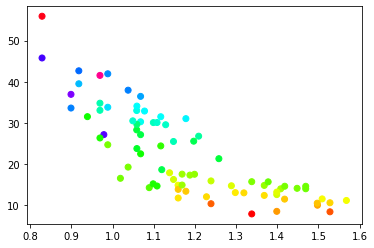

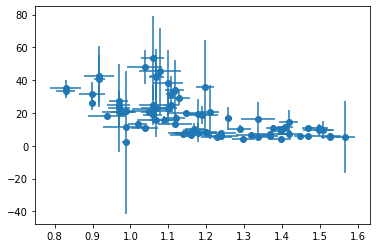

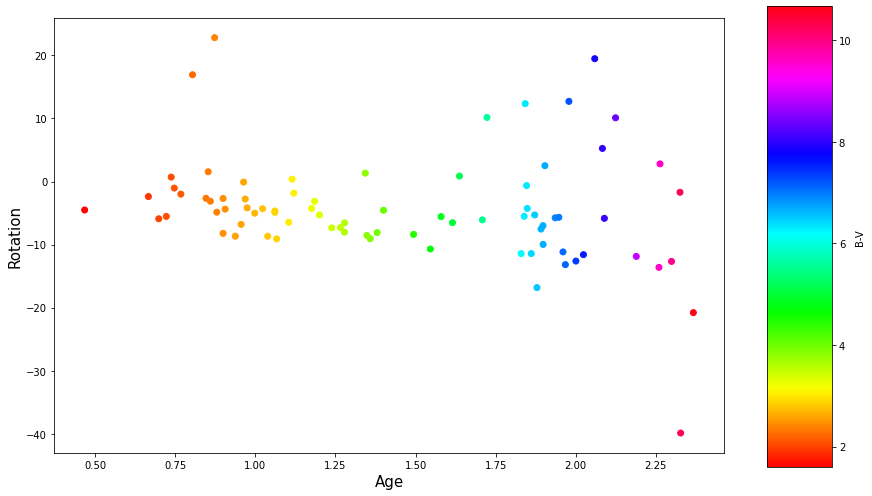

In [ ]:
data = np.array([te, p, age, mass]).T
a = 0.5189
b=0.75
c=0.4
d=0.601
f = -0.6
X1 = np.log(data[:,2]) #age
X2 = r.t2bv(data[:,0])#data[::al,2] #B_V
X3 = data[:, 3] #mass
x = mean_fn(X1, X2, a, b, c, d)
plt.scatter(X3, x, c=X2, cmap='hsv')
plt.show()
plt.errorbar(X3, p, xerr=mass_error, yerr=p_error, fmt='o')#, c=X2, cmap='hsv')
subtract = data[:,1]-x
plt.show()
fig = plt.figure(figsize=(12, 8))
plt.scatter(X1, subtract, c=data[:,2], cmap='hsv')
plt.xlabel('Age', size=15)
plt.ylabel('Rotation', size=15)
#plt.subplots_adjust(bottom=np.min(X2), top=np.max(X2))
cax = plt.axes([0.95, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax, label='B-V')
plt.show()


In [75]:
tf.enable_v2_behavior()
t1 = time.perf_counter()

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# observations from a known function at some random points.
X1 = np.log(age) #age
X2 = np.log10(te)#data[::al,2] #B_V
X3 = np.array(mass)
observation_index_points = np.dstack([X1, X2]).reshape(-1, 2)
observation_index_error =np.dstack([np.array(age_error/age), 0.43*np.array(tee)/np.array(te)]).reshape(-1, 2)
shape = np.array(observation_index_points.shape)
resolution = len(X2)
X1_test = np.log(np.linspace( np.min(data[::,2]), np.max(data[::,2]), num=resolution ))
X2_test = np.linspace( np.min(X2), np.max(X2), num=resolution )
X3_test = np.linspace( np.min(X3), np.max(X3), num=resolution )
X_test = np.dstack([X1_test, X2_test]).reshape(resolution,2)# resolution, resolution, 3)

a = 0.5189
b=0.75
c=0.4
d=0.601

Y = observations = (np.array(p) - mean_fn(X1, r.t2bv(np.array(te)), a, b, c, d))
noise_variance = p_error

sigma_init = 0.2*(max(Y) - min(Y))**0.5
l_scale = max(X2) - min(X2)
gaussian_process_model = tfd.JointDistributionSequential([
  tfd.LogNormal(sigma_init*np.ones(shape), np.float64(.00001)),
  tfd.LogNormal(l_scale*np.ones(shape), np.float64(.00001)),
  tfd.LogNormal(observation_index_points, observation_index_error),
  # tfd.Normal(X2.reshape(-1), 0.04*X1.reshape(-1)),
  # tfd.Normal(X3.reshape(-1), 0.04*X1.reshape(-1)),
  lambda amplitude, length_scale, observations1_: tfd.GaussianProcess(
      kernel=psd_kernels.ExponentiatedQuadratic(amplitude, length_scale), 
      index_points=observations1_, observation_noise_variance=observation_index_error)])

initial_chain_states = [
    sigma_init * tf.ones(shape, dtype=np.float64, name='init_amplitude'),
    l_scale * tf.ones(shape, dtype=np.float64, name='init_length_scale'),
    tf.convert_to_tensor(observation_index_points, dtype=np.float64, name='observations1_')]
    # tf.convert_to_tensor(X2.reshape(-1), dtype=np.float64, name='observations2_'),
    # tf.convert_to_tensor(X3.reshape(-1), dtype=np.float64, name='observations3_')]

unconstraining_bijectors = [
    tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus(),
    # tfp.bijectors.Softplus(),
    tfp.bijectors.Softplus()]

def unnormalized_log_posterior(*args):
  return gaussian_process_model.log_prob(*args, x=observations)

num_results = 500
num_burnin_steps = 1000
@tf.function
def run_mcmc():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      num_steps_between_results=4,
      current_state=initial_chain_states,
      kernel=tfp.mcmc.SimpleStepSizeAdaptation(
          inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
              target_log_prob_fn=unnormalized_log_posterior,
              step_size=[np.float64(1e-5)],
              num_leapfrog_steps=3), 
              num_adaptation_steps=int(num_burnin_steps)),
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
[
      amplitudes,
      length_scales,
      observations1_#, observations2_,observations3_
], is_accepted = run_mcmc()


print("Acceptance rate: {}".format(np.mean(is_accepted)))
#observation_index_points = np.dstack([observations1_.numpy()[0], observations2_.numpy()[0], observations3_.numpy()[0]]).reshape(-1,3)
observation_index_points = np.mean(observations1_,axis=0)#np.dstack([observations1_.numpy()[0], observations2_.numpy()[0], observations3_.numpy()[0]]).reshape(-1,3)
observations_l = np.array(p) - mean_fn(observation_index_points[:,0], r.t2bv(10**observation_index_points[:,1]), a, b, c, d)
#Y = observations = np.array(p) - mean_fn(observation_index_points[:,0], r.t2bv(10**(observation_index_points[:,1])), a, b, c, d)

gp = tfd.GaussianProcessRegressionModel(
    kernel=psd_kernels.ExponentiatedQuadratic(np.mean(amplitudes), np.mean(length_scales)),
    index_points=X_test,
    observation_index_points=observation_index_points,
    observations= observations_l,
    observation_noise_variance=noise_variance)

#print("Final NLL = {}".format(neg_log_likelihood_))

samples = gp.sample(10).numpy()
var = np.array(gp.variance())
# ==> 10 independently drawn, joint samples at `index_points`.
# ==> 10 independently drawn, noisy joint samples at `index_points`
t2 = time.perf_counter()
print()


Acceptance rate: 0.5442784810126582



'\n, var_names=("amplitudes",\n      "length_scales",\n      "observation_noise_variances"))'

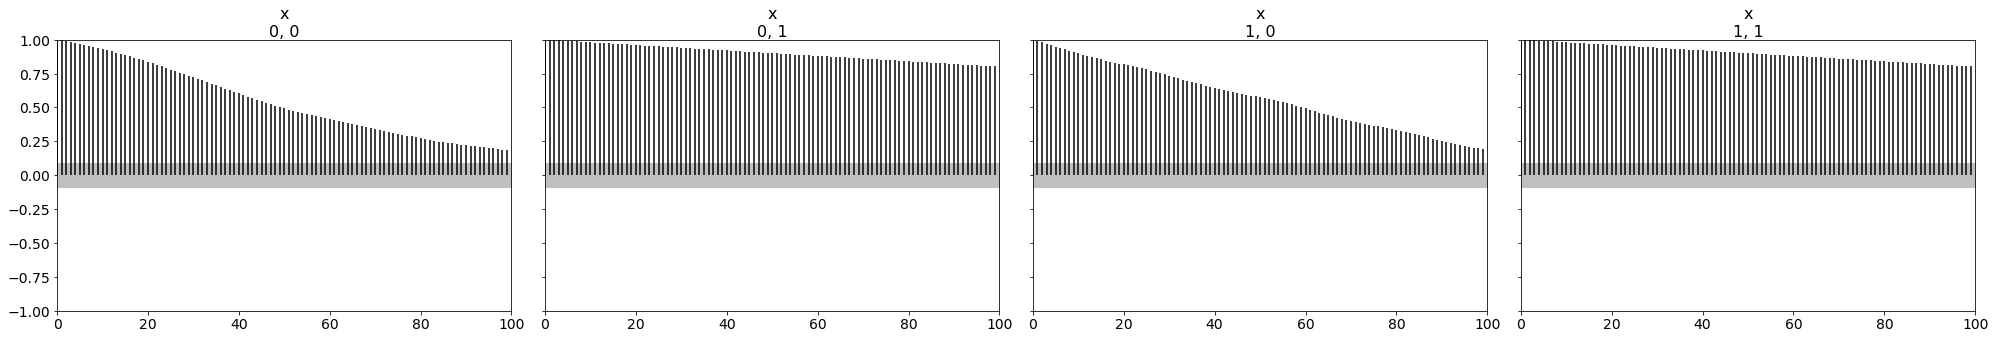

In [76]:
var1 = np.array([
      observations1_[:,0], observations1_[:,1]])
az.plot_autocorr(var1)
'''
, var_names=("amplitudes",
      "length_scales",
      "observation_noise_variances"))'''

In [77]:
numElems = len(Y)
sample = samples[0] + mean_fn(observation_index_points[:,0], r.t2bv(10**(np.array(observation_index_points[:,1]))), a ,b ,c ,d)
idx = np.round(np.linspace(0, len(np.array(sample).reshape(numElems**2)) - 1, numElems)).astype(int)
# Picks equal spaced elements from (longer) prediction array so that its shape of data

mu_test = (np.array(sample).reshape(numElems**2)[idx])
sd_test = (np.array(var).reshape(numElems**2)[idx]) 

vals = np.sort([mu_test, sd_test], axis=1)

print(np.mean(Y))


-4.433795515879334


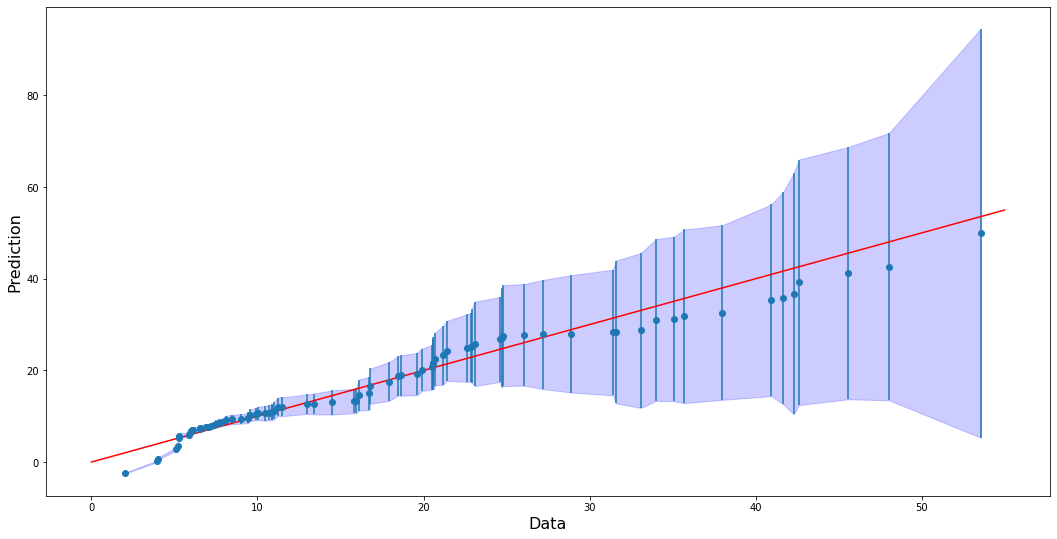

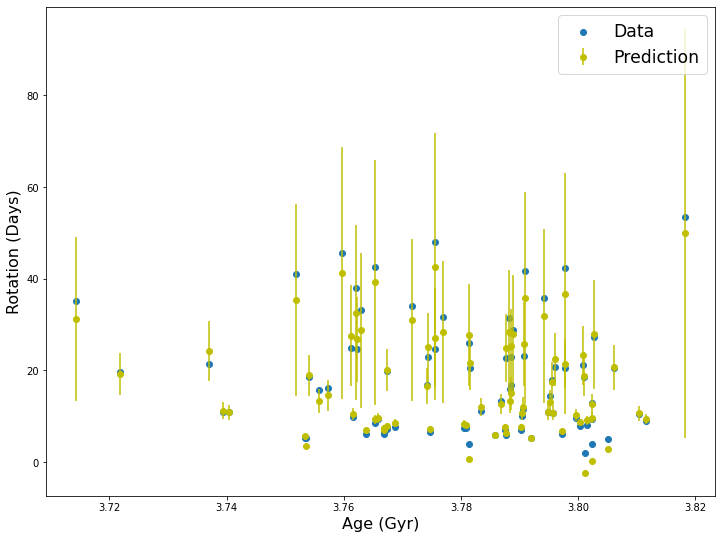

In [78]:
plt.figure(figsize=(18,9))
font = {'size': 16,
        }
#plt.errorbar(np.sort(data[::al, 1]), vals[0,:], yerr=vals[1,:]**0.5, fmt='bo')
plt.fill_between(np.sort(p), vals[0,:] - vals[1,:], vals[0,:] + vals[1,:], color='blue', alpha=0.2)
plt.errorbar(np.sort(p), np.sort(mu_test), yerr=vals[1,:], fmt='o')
x = np.linspace(0, 55)
plt.plot(x, x , 'r')
plt.xlabel('Data', fontdict=font)
plt.ylabel('Prediction', fontdict=font)

plt.figure(figsize=(12,9))
plt.errorbar(X2, np.sort(vals[0]), yerr=vals[1], fmt='o', c='y', label='Prediction')
plt.scatter(X2, np.sort(p), label='Data')
plt.xlabel('Age (Gyr)', fontdict=font)
plt.ylabel('Rotation (Days)', fontdict=font)
plt.legend(fontsize='xx-large')


(79,)


Text(0, 0.5, 'Frequency')

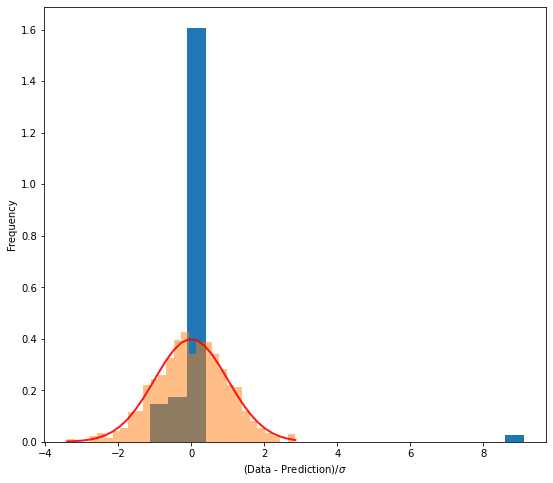

In [79]:
Z = (np.sort(p)-vals[0,:])/(vals[1,:]**2 +p_error**2)
print(Y.shape)
plt.figure(figsize=(9,8))
plt.hist(Z, density=True, bins=20)
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, alpha=0.5)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', alpha=0.9)
plt.xlabel('(Data - Prediction)/$\sigma$')
plt.ylabel('Frequency')

(79,)


Text(0, 0.5, 'Frequency')

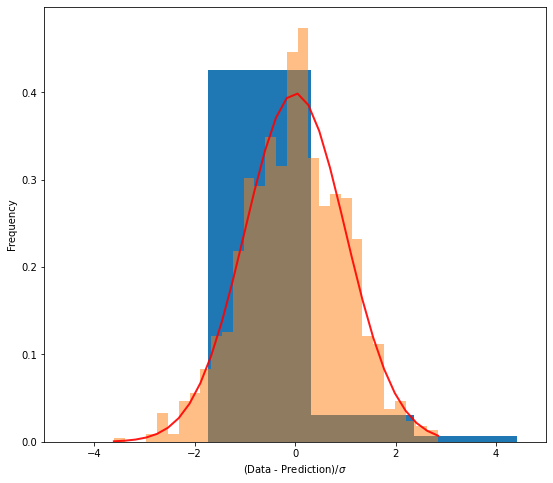

In [83]:
Z = (np.sort(p)-vals[0,:])/vals[1,:]
print(Y.shape)
plt.figure(figsize=(9,8))
plt.hist(Z, density=True, bins=20)
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 30, density=True, alpha=0.5)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', alpha=0.9)
plt.xlim((-5,5))
plt.xlabel('(Data - Prediction)/$\sigma$')
plt.ylabel('Frequency')

In [ ]:
import collections 
PooledModel = collections.namedtuple('PooledModel', ['Amplitude1','Length_Scale1', 'Obs'])
samplesN = [
      amplitudes,
      length_scales,
      observations1_
]
pooled_samples = PooledModel._make(samplesN)

In [ ]:
for var2, var_samples in pooled_samples._asdict().items():
  print('R-hat for ', var2, ':\t',
        tfp.mcmc.potential_scale_reduction(var_samples).numpy())

R-hat for  Amplitude1 :	 [3.26842211e+25 5.51324622e+24]
R-hat for  Length_Scale1 :	 [2.29018024e+18 2.31755938e+18]
R-hat for  Obs :	 [2.29287686e+27 6.45943990e+23]


In [ ]:
import seaborn as sns
def plot_traces(var_name, samples, num_chains):
  if isinstance(samples, tf.Tensor):
    samples = samples.numpy() # convert to numpy array
  fig, axes = plt.subplots(1, 2, figsize=(14, 1.5), sharex='col', sharey='col')
  for chain in range(num_chains):
    axes[0].plot(samples[:, chain], alpha=0.7)
    axes[0].title.set_text("'{}' trace".format(var_name))
    sns.kdeplot(samples[:, chain], ax=axes[1], shade=False)
    axes[1].title.set_text("'{}' distribution".format(var_name))
    axes[0].set_xlabel('Iteration')
    axes[1].set_xlabel(var_name)
  plt.show()

ValueError: ignored

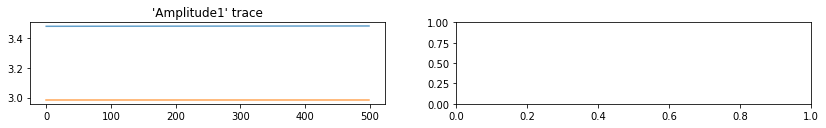

In [ ]:
for var1, var_samples in pooled_samples._asdict().items():
  plot_traces(var1, samples=var_samples, num_chains=4)